Question 1:
How has the public perception of anti-vaccine conspiracy via YouTube changed during the last five years?

In [9]:
import sys

!{sys.executable} -m pip install spacy

!{sys.executable} -m spacy download en_core_web_sm

!{sys.executable} -m pip install --upgrade scipy --no-cache-dir

!{sys.executable} -m pip uninstall numpy -y
!{sys.executable} -m pip install numpy==1.24.4 --no-cache-dir

!{sys.executable} pip install pandas==1.5.3 --no-cache-dir


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------ --------------------------------- 2.1/12.8 MB 13.6 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 13.5 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 13.1 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 12.8 MB/s  0:00:01
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
^C
Found existing installation: numpy 2.3.2
Uninstalling numpy-2.3.2:
  Successfully uninstalled numpy-2.3.2


You can safely remove it manually.
You can safely remove it manually.


     ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
     ------- -------------------------------- 2.1/10.9 MB 13.5 MB/s eta 0:00:01
     ------------------ --------------------- 5.0/10.9 MB 13.4 MB/s eta 0:00:01
     ---------------------------- ----------- 7.9/10.9 MB 13.4 MB/s eta 0:00:01
     ------------------------------------- - 10.5/10.9 MB 13.3 MB/s eta 0:00:01
     ---------------------------------------- 10.9/10.9 MB 13.3 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [32 lines of output]
  Traceback (most recent call last):
    File "C:\Users\momok\.virtualenvs\momok-1TYO14BV\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
      ~~~~^^
    File "C:\Users\momok\.virtualenvs\momok-1TYO14BV\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_val"] = hook(**hook_input["kwargs"])
                               ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\momok\.virtualenvs\momok-1TYO14BV\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 137, in get_requires_for_build_wheel
      backend = _build_backend()
    File "C:\Users\momok\.virtualenvs\momok-1TYO14BV\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 70, in _build_backend
      obj = impor

   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/38.5 MB 11.8 MB/s eta 0:00:04
   ---- ----------------------------------- 4.7/38.5 MB 12.0 MB/s eta 0:00:03
   ------- -------------------------------- 7.3/38.5 MB 11.8 MB/s eta 0:00:03
   ---------- ----------------------------- 10.2/38.5 MB 12.2 MB/s eta 0:00:03
   ------------- -------------------------- 13.1/38.5 MB 12.5 MB/s eta 0:00:03
   ---------------- ----------------------- 15.7/38.5 MB 12.6 MB/s eta 0:00:02
   ------------------ --------------------- 17.8/38.5 MB 12.4 MB/s eta 0:00:02
   -------------------- ------------------- 20.2/38.5 MB 12.0 MB/s eta 0:00:02
   ----------------------- ---------------- 23.1/38.5 MB 12.1 MB/s eta 0:00:02
   -------------------------- ------------- 25.2/38.5 MB 11.8 MB/s eta 0:00:02
   ---------------------------- ----------- 27.8/38.5 MB 11.9 MB/s eta 0:00:01
   ------------------------------- -------- 29.9/38.5 MB 11.7 MB

  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import numpy as np
print(np.__version__)

1.24.4


In [14]:
import pandas as pd
import json
import ast
from collections import Counter
from keybert import KeyBERT
import re


data = pd.read_csv('one.csv')

# The next line cleans the data by removing duplicate lines.
data.drop_duplicates(inplace = True)

data['Published At'] = pd.to_datetime(data['Published At'])

time_periods = [
    ('2020', '2020-01-01', '2020-12-31'),
    ('2021', '2021-01-01', '2021-12-31'),
    ('2022', '2022-01-01', '2022-12-31'),
    ('2023', '2023-01-01', '2023-12-31'),
    ('2024', '2024-01-01', '2024-12-31'),
    ('2025', '2025-01-01', '2025-12-31'),
]
result = {}

def extract_keywords(data):
    model = KeyBERT()
    keywords_list = []

    for item in data:
        text = str(item)
        # Extract single-word keywords
        kw_single = model.extract_keywords(text, keyphrase_ngram_range=(1,1))
        keywords_list.extend(kw_single)

    ignore_words = []

    flattened_keywords = [kw for kw, score in keywords_list if kw.lower() not in ignore_words]

    keywords_df = pd.DataFrame(Counter(flattened_keywords).items(), columns=["words", "numbers"])
    frequent_words = keywords_df.loc[keywords_df['numbers'] > 1].sort_values(by='numbers', ascending=False)
    return frequent_words

for name, start, end in time_periods:
    filter = (data['Published At'] >= start) & (data['Published At'] <= end)
    filtered = data[filter]

    frequent_words = extract_keywords(filtered['TOP 10 comments'].astype(str).tolist())
    result[name] = {
            'keywords': frequent_words.head(15).to_dict(orient="records")
        }

with open('answer_one.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, indent=2)

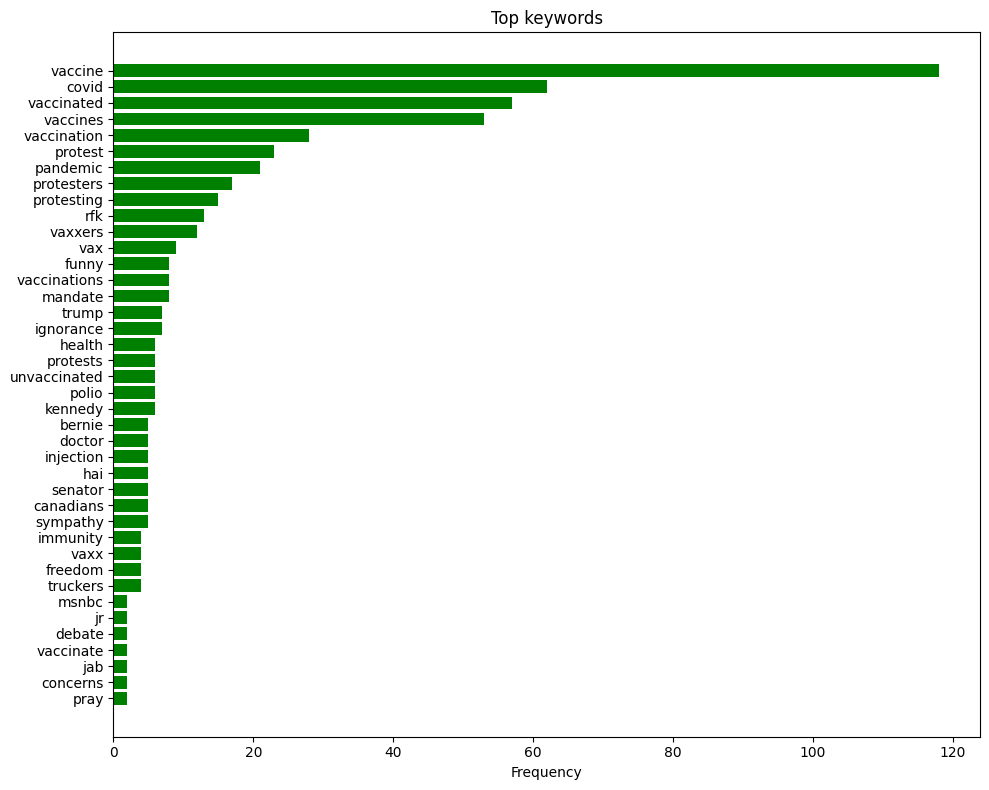

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

import json
from collections import defaultdict

with open('answer_one.json', 'r', encoding='utf-8') as file:
    keywords = json.load(file)

frequencies_all_years = defaultdict(int)

for year, content in keywords.items():
    for kw in content['keywords']:
        keyword = kw["words"]
        frequency = int(kw["numbers"])  
        frequencies_all_years[keyword] += frequency

data = pd.DataFrame(frequencies_all_years.items(), columns=['Keyword', 'Frequency'])
data = data.sort_values(by='Frequency', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(data['Keyword'], data['Frequency'], color='green')
plt.xlabel('Frequency')
plt.title(f'Top keywords')
plt.tight_layout()
plt.show()

